In [14]:
%load_ext autoreload
%autoreload 2

import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import numpy as np
import pandas as pd
import seaborn as sn
import json
import glob, os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from numpy.random import seed
from scipy.stats import kruskal
from scipy.stats import levene

from termcolor import colored
import my_plots
from matplotlib.pylab import savefig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# plot settings

lw = 1.5

fs = 13

params = {
    'axes.labelsize': fs,
    'font.size': fs,
    'legend.fontsize': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'text.usetex': False,
    'figure.figsize': [6, 6],
    'boxplot.boxprops.linewidth' : lw,
    'boxplot.whiskerprops.linewidth' : lw,
    'boxplot.capprops.linewidth' : lw,
    'boxplot.medianprops.linewidth' : lw,
    'text.usetex' : True,
    'font.family' : 'serif',

   }
mpl.rcParams.update(params)

In [16]:
def dfFromJSON(file):
    with open(file) as f:
        temp = []
        for line in f:
            temp.append(json.loads(line))
            
    df = pd.io.json.json_normalize(temp[0]['allLogs'])
    df.columns = df.columns.map(lambda x: x.split("*.")[-1])
    return df

def dfFromCSV(file):
    df = pd.read_csv(file)

    if 'rosout__file' in list(df):
        df = df.drop(['Unnamed: 0', 'rosout__file', 'rosout__function', 'rosout__level', 'rosout__line', 'rosout__msg', 'rosout__name', 'rosout_agg__line', 'rosout_agg__msg', 'rosout_agg__name', 'rosout_agg__file', 'rosout_agg__function', 'rosout_agg__level'], axis=1)
    df = df.interpolate()
    df = df.iloc[::20, :]
    df = df.dropna()
    return df

In [17]:
def appendToLogs(file, log, _type):
    df = dfFromJSON(file)
    log[_type].append(df)

In [18]:
path_to_folder = "/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/"
subjects = glob.glob(path_to_folder + "*/" + "*/")

logs = {}
for curr in subjects:
    logs[curr] = []
    
subjects.sort()
subjects

['/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_02/motion/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_02/remote/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_2/motion/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_2/remote/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_3/motion/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_3/remote/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_4/motion/',
 '/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_4/remote/']

## Remove outliers

In [19]:
# # used to remove outliers

# subjects.remove(subjects[5])
# subjects.remove(subjects[4])

# logs = {}
# for curr in subjects:
#     logs[curr] = []
    
# subjects

# Import data

In [20]:
EXP_N_THOMAS = 4
EXP_N = 5

for subject in subjects:
#     print(subject)
    files = glob.glob(subject+"exp3/"+"*.csv")
    files.sort()
    
    for i in files:
        print(i)
    
#     if len(files) != EXP_N and len(files) != EXP_N_THOMAS:
#         print(subject)
#         print('wrong number of experiments!')
#         break
    for file in files:
        print('.')
        logs[subject].append(dfFromCSV(file))

/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_02/motion/exp3/1.csv
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_02/motion/exp3/2.csv
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_02/motion/exp3/3.csv
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_02/motion/exp3/4.csv
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_02/motion/exp3/5.csv
.
.
.
.
.
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_02/remote/exp3/1.csv
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/rosbags/haptics/sub_02/remote/exp3/2.csv
/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA

In [21]:
fields = ['first motion', 'last motion', 'first remote', 'last remote']
interfaces = ['motion', 'remote']

sub_remote = [x for x in subjects if 'remote' in x]
sub_motion = [x for x in subjects if 'motion' in x]

t = [logs[x] for x in sub_motion]
logs['motion'] = []
for i in t:
    for j in i:
        logs['motion'].append(j)

t = [logs[x] for x in sub_remote]
logs['remote'] = []
for i in t:
    for j in i:
        logs['remote'].append(j)

logs['first motion'] = [logs[x][0] for x in sub_motion]
logs['last motion'] = [logs[x][-1] for x in sub_motion]
logs['first remote'] = [logs[x][0] for x in sub_remote]
logs['last remote'] = [logs[x][-1] for x in sub_remote]

# logs['last remote']

# Analysis scripts

In [22]:
def t_test_kruskal(X, Y):
    
    # Kruskal-Wallis H-test
    
    # seed the random number generator
    seed(1)
    
    # compare samples
    stat, p = kruskal(X, Y)
    
    return [stat, p]

def t_test_levene(X, Y):
    
    # Kruskal-Wallis H-test
    
    # seed the random number generator
    seed(1)
    
    # compare samples
    stat, p = levene(X, Y)
    
    return [stat, p]

def str_from_p(p):
    
    if p<0.01:
        add_str = ' !!!!!!!!!!'
    elif p<0.05:
        add_str = ' !!!!!!'
    elif p<0.1:
        add_str = ' !'
    else:
        add_str = ''
        
    return add_str

def print_p(p):
    
    col = None
    
    if p<0.01:
        col = 'green'
    elif p<0.05:
        col = 'yellow'
    elif p<0.1:
        col = 'red'
        
    if col is not None:
        print(colored('p = '+ str(p) + str_from_p(p), col))
    else:
        print('p = '+ str(p) + str_from_p(p))

def runBasicAnalysis(f):
    
    var = {}

    var['means'] = []
    var['stds'] = []

    for i in fields:
        var[i] = []
        for j in logs[i]:
            var[i].append(f(j))
        print(i)
        print(var[i])

        var['means'].append(np.mean(var[i]))
        var['stds'].append(np.std(var[i]))

        print('mean = ', var['means'][-1])
        print('std = ', var['stds'][-1])

        print()
        
            
    for idx,i in enumerate(fields):
        for j in fields[idx+1:]:
            if i != j:
                
                t, p = t_test_kruskal(var[i],var[j])
                
                print (i,j)
                print_p(p)
            
    var['diff mot'] = 1-np.array(var['last motion'])/np.array(var['first motion'])
    var['diff rem'] = 1-np.array(var['last remote'])/np.array(var['first remote'])

    print()
    print('motion ratio')
    print(var['diff mot'])
    print(np.mean(var['diff mot']))
    print(np.std(var['diff mot']))
    print()
    print('remote ratio')
    print(var['diff rem'])
    print(np.mean(var['diff rem']))
    print(np.std(var['diff rem']))

    t, p = t_test_kruskal(var['diff mot'], var['diff rem'])

    print()
    print('p = ', p, str_from_p(p))
            
    var['diff first'] = 1-np.array(var['first motion'])/np.array(var['first remote'])
    var['diff last'] = 1-np.array(var['last motion'])/np.array(var['last remote'])

    print()
    print('firts ratio')
    print(var['diff first'])
    print(np.mean(var['diff first']))
    print(np.std(var['diff first']))
    print()
    print('last ratio')
    print(var['diff last'])
    print(np.mean(var['diff last']))
    print(np.std(var['diff last']))

    t, p = t_test_kruskal(var['diff first'], var['diff last'])

    print()
    print('p = ', p, str_from_p(p))
            
    return var

def runHapticsXAnalysis(f):
    
    var = {}

    var['means'] = []
    var['stds'] = []

    for i in interfaces:
        var[i] = []
        for j in logs[i]:
            var[i].append(f(j))
        print(i)
        print(var[i])

        var['means'].append(np.mean(var[i]))
        var['stds'].append(np.std(var[i]))

        print('mean = ', var['means'][-1])
        print('std = ', var['stds'][-1])

        print()
        
            
    for idx,i in enumerate(interfaces):
        for j in interfaces[idx+1:]:
            if i != j:
                
                t, p = t_test_kruskal(var[i],var[j])
                print_p(p)
                
    return var

def runHapticsZAnalysis(f, logs):
    
    varX = {}
    varY = {}

    varX['means'] = []
    varX['stds'] = []
    varY['means'] = []
    varY['stds'] = []

    for i in interfaces:
        varX[i] = []
        varY[i] = []
        for jdx, j in enumerate(logs[i]):
#             j = logs[i][10]

            ret = f(j, [i, jdx])
            varX[i].append(ret[0])
            varY[i].append(ret[1])
        print(i)
        print(varX[i])
        print(varY[i])

        varX['means'].append(np.mean(varX[i]))
        varX['stds'].append(np.std(varX[i]))
        varY['means'].append(np.mean(varY[i]))
        varY['stds'].append(np.std(varY[i]))

        print('mean = ', varX['means'][-1])
        print('std = ', varX['stds'][-1])
        print('mean = ', varY['means'][-1])
        print('std = ', varY['stds'][-1])

        print()
        
            
    for idx,i in enumerate(interfaces):
        for j in interfaces[idx+1:]:
            if i != j:
                
                tX, pX = t_test_kruskal(varX[i],varX[j])
                tY, pY = t_test_kruskal(varY[i],varY[j])
                
                print('')
                print(i,j, ' X')
                print_p(pX)
                print('')
                print(i,j, ' Y')
                print_p(pY)
                
    return [varX, varY]

def basic_plot(var):
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(131)
    ax.bar([0, 1, 2, 3],
       var['means'],
       yerr=var['stds'])

    plt.xticks(range(4), fields, rotation = 10)

    ax = fig.add_subplot(132)
    ax.bar([0, 1],
       [np.mean(var['diff mot']), np.mean(var['diff rem'])],
       yerr=[np.std(var['diff mot']), np.std(var['diff rem'])])
    
    plt.xticks(range(2), ['motion', 'remote'], rotation = 10)

    ax = fig.add_subplot(133)
    ax.bar([0, 1],
       [np.mean(var['diff first']), np.mean(var['diff last'])],
       yerr=[np.std(var['diff first']), np.std(var['diff last'])])
    
    plt.xticks(range(2), ['first', 'last'], rotation = 10)

In [23]:
def moving_average(data_set, periods=3, fill_with_zeros = True):
    
    if data_set.size < periods:
        return data_set
    
    if isinstance(data_set, pd.DataFrame):
        print('a')
        data_set.index = range(len(data_set))

    weights = np.ones(periods) / periods
    
    ma = np.convolve(data_set, weights, mode='valid')

    if fill_with_zeros:
        fill_before = np.ones(int(np.ceil((len(data_set) - len(ma))/2))) * data_set[0]
        fill_after = np.ones(int(np.floor((len(data_set) - len(ma))/2))) * data_set[-1]
        ma = np.hstack([fill_before, ma, fill_after])
    
    return ma

def filter_position(df, steps):
    
    l = moving_average(df['dronePosition.x'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.x'] = np.append([l[0]]*(steps-1), l)
    l = moving_average(df['dronePosition.y'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.y'] = np.append([l[0]]*(steps-1), l)
    l = moving_average(df['dronePosition.x'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.x'] = np.append([l[0]]*(steps-1), l)
    return df

def running_average(signal, steps):
    
    l = moving_average(signal, periods=steps, fill_with_zeros = False)
    out = np.append([l[0]]*(steps-1), l)
    return out

# Plot Trajectories

KeyError: 'dronePosition.x'

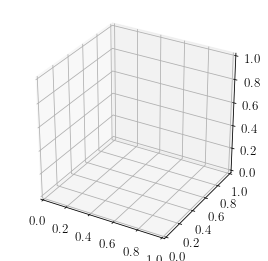

In [24]:
mpl.rcParams.update(params)

plt.figure(figsize = [10,10])

for idx,i in enumerate(fields):
    ax = plt.subplot(2, 2, 1+idx, projection='3d')
    for idx1,log in enumerate(logs[i]):
        ax.plot(log['dronePosition.x'],log['dronePosition.z'],log['dronePosition.y'], label = str(idx1))
#         print(len(log))
    plt.legend()
    plt.title(fields[idx])
#     define_plot_pos(ax)

# Collision Analysis

In [31]:
coll_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Bidir - haptics ZY collisions - HW - Sheet1.csv')

In [32]:
coll = {}

coll['motion'] = coll_df[coll_df['Interface']=='Motion']
coll['remote'] = coll_df[coll_df['Interface']=='Remote']


coll['first motion'] = coll['motion'][coll['motion']['Run']==1]
coll['last motion'] = coll['motion'][coll['motion']['Run']==5]
coll['first remote'] = coll['remote'][coll['remote']['Run']==1]
coll['last remote'] = coll['remote'][coll['remote']['Run']==5]



consider all runs

mean motion =  0.5
std motion =  0.5
mean remote =  1.75
std remote =  0.82915619758885

total motion =  2
total remote =  7


consider first runs

mean motion =  0.0
std motion =  0.0
mean remote =  0.0
std remote =  0.0

total motion =  0
total remote =  0


consider last runs

mean motion =  0.25
std motion =  0.4330127018922193
mean remote =  0.5
std remote =  0.5

total motion =  1
total remote =  2



Text(0.5, 1.0, 'Collisions - last run')

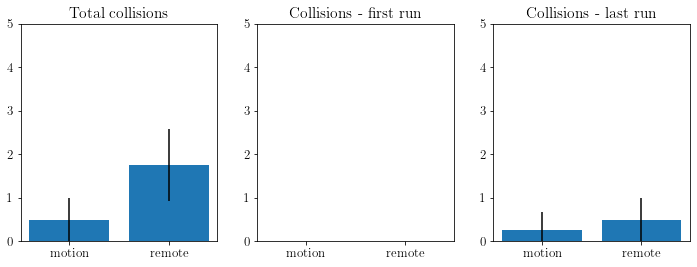

In [34]:
def compute_mean_std_collisions(data_m, data_r):
    
    coll_per_sub_m = []
    
    for sub in np.unique(data_m['Subject']):
        sub_coll = data_m[data_m['Subject']==sub]
        
        coll_per_sub_m.append(sub_coll['Collided Y'].sum())
        
    coll_per_sub_r = []
    
    for sub in np.unique(data_r['Subject']):
        sub_coll = data_r[data_r['Subject']==sub]
        
        coll_per_sub_r.append(sub_coll['Collided Y'].sum())
    
    mean_m = np.mean(coll_per_sub_m)
    std_m = np.std(coll_per_sub_m)
    mean_r = np.mean(coll_per_sub_r)
    std_r = np.std(coll_per_sub_r)

    print('mean motion = ', mean_m)
    print('std motion = ', std_m)
    print('mean remote = ', mean_r)
    print('std remote = ', std_r)
    print('')
    print('total motion = ', np.sum(coll_per_sub_m))
    print('total remote = ', np.sum(coll_per_sub_r))
    print('')

#     t, p = t_test_kruskal(coll_per_sub_m, coll_per_sub_r)

#     print_p(p)
    
    return [coll_per_sub_m, coll_per_sub_r]

print('')
print('consider all runs')
print('')
all_m, all_r = compute_mean_std_collisions(coll['motion'], coll['remote'])
    
print('')
print('consider first runs')
print('')
first_m, first_r = compute_mean_std_collisions(coll['first motion'], coll['first remote'])
    
print('')
print('consider last runs')
print('')
last_m, last_r = compute_mean_std_collisions(coll['last motion'], coll['last remote'])


    
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)
ax.bar([0, 1],
   [np.mean(all_m), np.mean(all_r)],
      yerr = [np.std(all_m), np.std(all_r)])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 5])
plt.title('Total collisions')

ax = fig.add_subplot(132)
ax.bar([0, 1],
   [np.mean(first_m), np.mean(first_r)],
      yerr = [np.std(first_m), np.std(first_r)])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 5])
plt.title('Collisions - first run')

ax = fig.add_subplot(133)
ax.bar([0, 1],
   [np.mean(last_m), np.mean(last_r)],
      yerr = [np.std(last_m), np.std(last_r)])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 5])
plt.title('Total collisions')
plt.title('Collisions - last run')

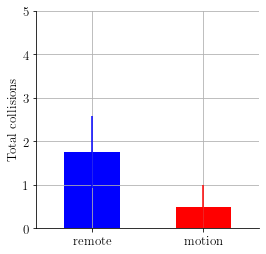

In [119]:

c1 = 'b'
c2 = 'r'

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.bar([1],
   [np.mean(all_r),],
      yerr = [np.std(all_r)], color =c1, ecolor = c1, width=0.5 )
ax.bar([2],
   [np.mean(all_m)],
      yerr = [np.std(all_m)], color =c2, ecolor = c2, width=0.5 )

plt.xticks([1,2], ['remote', 'motion'])
plt.ylim([0, 5])
plt.xlim([0.5, 2.5])
plt.ylabel('Total collisions')
plt.grid()

        
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

savefig('collisions_Y_HW.pdf', bbox_inches='tight')

# Go-through passing Analysis

In [117]:
def comp_max_dist(df, info):

    tit = info[0] + str(info[1])
    
    dist_obstacle = 1.55
    collider = 0.0

    x_cross = dist_obstacle + collider
    
    x = df['vrpn_client_node_cf1_pose__pose_position_z'].values
#     plt.figure()
#     plt.plot(-df['vrpn_client_node_cf1_pose__pose_position_y'], df['vrpn_client_node_cf1_pose__pose_position_z'])
#     plt.plot([-4, 4], [x_cross, x_cross])
# #     plt.xlim(0.5,1)
# #     plt.ylim(-4,4)
#     plt.title(tit)
    
    ok = False
    for idx,i in enumerate(x):
        if idx>0:
            if x[idx-1]>x_cross and x[idx]<x_cross and -df['vrpn_client_node_cf1_pose__pose_position_y'].iloc[idx]>2.55:
#                 print(idx)
#                 ok = True
                break
    
    if df['vrpn_client_node_cf1_pose__pose_position_y'].iloc[idx]>0:
        
        x_cross = x_cross+0.1
        for idx,i in enumerate(x):
            if idx>0:
                if x[idx-1]>x_cross and x[idx]<x_cross and -df['vrpn_client_node_cf1_pose__pose_position_y'].iloc[idx]>2.55:
    #                 print(idx)
    #                 ok = True
                    break
        
    
#     print(ok)
    
#     if idx==x.shape:
#         print('WELLA')
#         x_cross = dist_obstacle + 0.1
        
#         for idx,i in enumerate(x):
#             if idx>0:
#                 if x[idx-1]>x_cross and x[idx]<x_cross:
#     #                 print(idx)
#                     break
    
                
#     print([df['vrpn_client_node_cf1_pose__pose_position_y'].iloc[idx], df['vrpn_client_node_cf1_pose__pose_position_z'].iloc[idx]])
    
    return [df['vrpn_client_node_cf1_pose__pose_position_x'].iloc[idx], df['vrpn_client_node_cf1_pose__pose_position_y'].iloc[idx]]

logs1 = logs.copy()

logs1.pop('remote')

cross_ret = runHapticsZAnalysis(comp_max_dist, logs)

motion
[-3.35485447778, -3.3375028610219997, -3.423076256460869, -3.39797151089, -3.3771773179366673, -3.2092347565829416, -3.38032078743, -3.32590842247, -3.3596446514133333, -3.332056403159, -3.41958665848, -3.3846786816916663, -3.3215241432188884, -3.4159277166657143, -3.45063964526, -3.2185990129185718, -3.278383255, -3.3030698895425]
[-2.948665804335556, -3.069798851014, -3.0472264186221736, -2.9945018291500003, -3.0389180183400004, -2.894165067113529, -2.872174263, -2.9087562561, -2.9996174971266667, -3.0260188817990006, -3.09568190575, -3.1640129486766666, -3.2380147775022223, -3.003537757054286, -2.9418552716599997, -2.99572903769, 1.7372355461099998, -3.0872704982775003]
mean =  -3.349453135995675
std =  0.06506926921960351
mean =  -2.7549283076167557
std =  1.0932082619556445

remote
[-3.4032455285366665, -3.4040227777794114, -3.342508684504545, -3.4304163456, -3.4768922237280777, -3.3192189693485, -3.332197260858, -3.3529320716860003, -3.41652739048, -3.3712825245344447, -3.

In [121]:
coord = ['X', 'Y']
cross = {}
x_center = -3.38
y_center = -3.05

cross_dic = {'X':cross_ret[0], 'Y':cross_ret[1]}
center = {'X':x_center, 'Y':y_center}

for c in coord:
    cross[c] = {}
    for i in interfaces:
        cross[c][i] = np.array(cross_dic[c][i]) - center[c]

[ 0.02514552  0.04249714 -0.04307626 -0.01797151  0.00282268  0.17076524
 -0.00032079  0.05409158  0.02035535  0.0479436  -0.03958666 -0.00467868
  0.05847586 -0.03592772 -0.07063965  0.16140099  0.10161674  0.07693011]
[ 1.01334196e-01 -1.97988510e-02  2.77358138e-03  5.54981708e-02
  1.10819817e-02  1.55834933e-01  1.77825737e-01  1.41243744e-01
  5.03825029e-02  2.39811182e-02 -4.56819057e-02 -1.14012949e-01
 -1.88014778e-01  4.64622429e-02  1.08144728e-01  5.42709623e-02
  4.78723555e+00 -3.72704983e-02]
[ 0.02514552  0.04249714 -0.04307626 -0.01797151  0.00282268  0.17076524
 -0.00032079  0.05409158  0.02035535  0.0479436  -0.03958666 -0.00467868
  0.05847586 -0.03592772 -0.07063965  0.16140099  0.07693011]
[ 0.1013342  -0.01979885  0.00277358  0.05549817  0.01108198  0.15583493
  0.17782574  0.14124374  0.0503825   0.02398112 -0.04568191 -0.11401295
 -0.18801478  0.04646224  0.10814473  0.05427096 -0.0372705 ]


<BarContainer object of 17 artists>

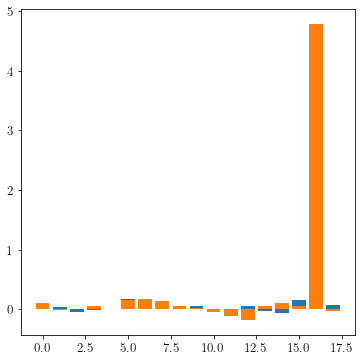

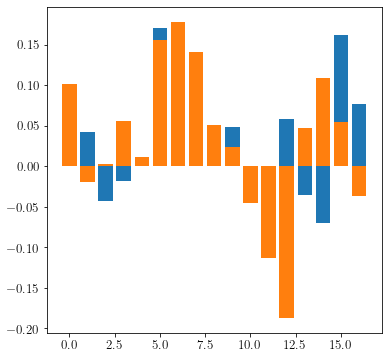

In [122]:
bug = 17
print(cross['X']['motion'])
print(cross['Y']['motion'])

plt.bar(range(0,18),cross['X']['motion'])
plt.bar(range(0,18),cross['Y']['motion'])

cross['X']['motion']= np.append(cross['X']['motion'][:bug-1], cross['X']['motion'][bug:])
cross['Y']['motion']= np.append(cross['Y']['motion'][:bug-1], cross['Y']['motion'][bug:])

print(cross['X']['motion'])
print(cross['Y']['motion'])

plt.figure()
plt.bar(range(0,17),cross['X']['motion'])
plt.bar(range(0,17),cross['Y']['motion'])

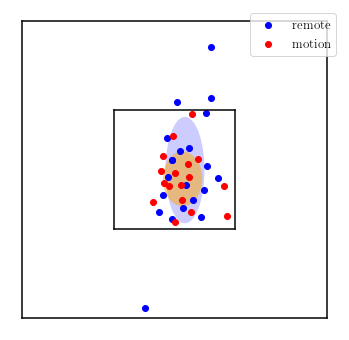

In [125]:
fig = plt.figure()
ax = fig.add_subplot(111)

# t1 = cross['Y']['remote']
# t2 = cross['Y']['motion'] 

cross['Y']['remote'] = -cross['Y']['remote']
cross['Y']['motion'] = -cross['Y']['motion']

# cross['X']['remote'] = t1
# cross['X']['motion'] = t2

ax.scatter(cross['X']['remote'], cross['Y']['remote'], color = 'b', label = 'remote')
ax.scatter(cross['X']['motion'], cross['Y']['motion'], color = 'r', label = 'motion')

l = 0.2
ax.plot([-l, -l], [-l, l] ,'k')
ax.plot([l, l], [-l, l] ,'k')
ax.plot([-l, l], [-l, -l] ,'k')
ax.plot([-l, l], [l, l] ,'k')
l = 0.5
ax.plot([-l, -l], [-l, l] ,'k')
ax.plot([l, l], [-l, l] ,'k')
ax.plot([-l, l], [-l, -l] ,'k')
ax.plot([-l, l], [l, l] ,'k')

# plt.xlim([-0.6, 0.6])
# plt.ylim([-0.6, 0.6])

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.legend(loc = 'upper right')


ellipse = Ellipse((np.mean(cross['X']['remote']), np.mean(cross['Y']['remote'])), width=np.std(cross['X']['remote'])*2,
        height=np.std(cross['Y']['remote'])*2,
        alpha=0.2,
        facecolor='blue', zorder=-2)
ax.add_patch(ellipse)


ellipse = Ellipse((np.mean(cross['X']['motion']), np.mean(cross['Y']['motion'])), width=np.std(cross['X']['motion'])*2,
        height=np.std(cross['Y']['motion'])*2,
        alpha=0.5,
        facecolor='orange', zorder=-1)
ax.add_patch(ellipse)
        
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

savefig('cross_Y_HW.pdf', bbox_inches='tight')

0.0340323056371041
0.06399312018238529
0.026366282769285078
0.06456375551541005
p = 0.6954288109995348
0.0011603365115819937
0.17950287359372805
0.030826759811082086
0.09245343781509693
p = 0.07254087568512559 !


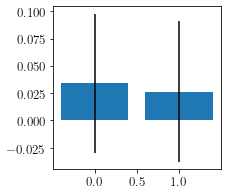

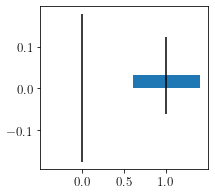

In [124]:
for c in coord:

    print(np.mean(cross[c]['remote']))
    print(np.std(cross[c]['remote']))
    print(np.mean(cross[c]['motion']))
    print(np.std(cross[c]['motion']))

    fig = plt.figure(figsize=[3,3])
    ax = fig.add_subplot(111)

    ax.bar([0,1], 
            [np.mean(cross[c]['remote']), np.mean(cross[c]['motion'])],
          yerr = [np.std(cross[c]['remote']), np.std(cross[c]['motion'])])

    print_p(t_test_levene(cross[c]['remote'], cross[c]['motion'])[1])

# TEST